# 0. Install and Import Dependencies

In [3]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      2.0.0
asttokens                    2.2.1
astunparse                   1.6.3
backcall                     0.2.0
beautifulsoup4               4.11.1
cachetools                   5.3.2
caer                         2.0.8
certifi                      2022.6.15
charset-normalizer           2.1.0
click                        8.1.3
colorama                     0.4.5
comm                         0.1.2
contourpy                    1.0.7
cycler                       0.11.0
debugpy                      1.6.6
decorator                    5.1.1
executing                    1.2.0
filelock                     3.13.4
Flask                        2.1.3
flatbuffers                  23.5.26
fonttools                    4.39.4
gast                         0.4.0
gdown                        5.1.0
google-auth                  2.25.1
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
g


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: C:\Users\Isfatul\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
!pip install opencv-python matplotlib imageio gdown tensorflow


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: C:\Users\Isfatul\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [6]:
tf.config.list_physical_devices('GPU')

[]

In [7]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [8]:
import gdown

In [9]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [10]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [11]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [12]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [13]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11], dtype=int64)>

In [14]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [15]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [16]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [17]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [18]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [19]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

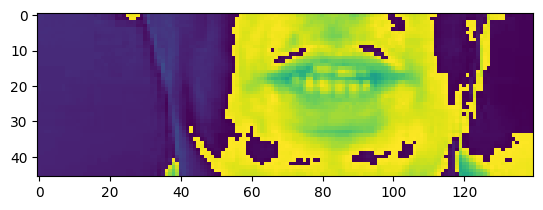

In [20]:
plt.imshow(frames[40])

In [21]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [22]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [23]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [24]:
from matplotlib import pyplot as plt

In [25]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [26]:
len(test)

50

In [27]:
frames, alignments = data.as_numpy_iterator().next()

In [28]:
len(frames)

2

In [29]:
sample = data.as_numpy_iterator()

In [30]:
val = sample.next(); val[0]

array([[[[[1.3178471 ],
          [1.2015665 ],
          [0.736444  ],
          ...,
          [0.27132148],
          [0.19380105],
          [0.19380105]],

         [[1.3953675 ],
          [1.1628063 ],
          [0.8527246 ],
          ...,
          [0.27132148],
          [0.19380105],
          [0.19380105]],

         [[1.472888  ],
          [1.472888  ],
          [1.2403268 ],
          ...,
          [0.3100817 ],
          [0.23256126],
          [0.23256126]],

         ...,

         [[1.1240461 ],
          [1.0852859 ],
          [1.0852859 ],
          ...,
          [0.        ],
          [0.        ],
          [0.        ]],

         [[1.0852859 ],
          [1.0852859 ],
          [1.0465257 ],
          ...,
          [9.883854  ],
          [9.883854  ],
          [9.883854  ]],

         [[1.0852859 ],
          [1.0852859 ],
          [1.0465257 ],
          ...,
          [9.883854  ],
          [9.883854  ],
          [9.883854  ]]],


        [[[1.3953

In [31]:
# imageio.mimsave('./animation.gif', val[0][0], fps=10)

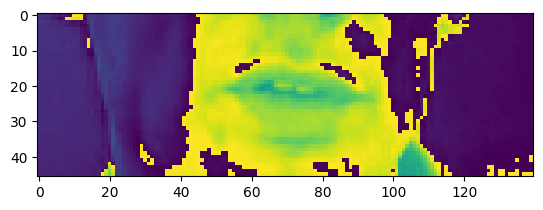

In [32]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [33]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place blue with x two please'>

# 3. Design the Deep Neural Network

In [34]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [35]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [36]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [38]:
5*17*75

6375

In [39]:
yhat = model.predict(val[0])

1/1 [==============================] - 4s 4s/step


In [40]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'    uuqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq'>

In [41]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'    uuqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq'>

In [42]:
model.input_shape

(None, 75, 46, 140, 1)

In [43]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [44]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [45]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [46]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [47]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [48]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [49]:
schedule_callback = LearningRateScheduler(scheduler)

In [50]:
example_callback = ProduceExample(test)

In [51]:
# model.fit(train, validation_data=test, epochs=5, callbacks=[checkpoint_callback, schedule_callback, example_callback])

# 5. Make a Prediction 

In [70]:
!python -c "import keras; print(keras.__version__)"

2.10.0


2024-05-05 16:11:58.084463: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2024-05-05 16:11:58.084754: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [69]:
model.load_weights('./models/checkpoint')
model.save('goal.keras')

In [53]:
test_data = test.as_numpy_iterator()

In [54]:
sample = test_data.next()

In [55]:
yhat = model.predict(sample[0])

1/1 [==============================] - 4s 4s/step


In [56]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white at d three soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place green with r five soon'>]

In [57]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [58]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place white at d three soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'place green with r five soon'>]

# Test on a Video

In [59]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [60]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [61]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 1s/step


In [62]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [63]:
print(decoded)

[[ 2  9 14 39 18  5  4 39  1 20 39 19 39 14  9 14  5 39  1  7  1  9 14  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  -1 -1 -1]]


In [64]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [65]:
model.evaluate(test)

50/50 [==============================] - 321s 3s/step - loss: 1.1001


1.1000863313674927

In [66]:
true_texts = []
predicted_texts = []


def decode_labels(decoded):
    return [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

# Iterate through the test dataset
for sample in test.as_numpy_iterator():
    # Get ground truth labels and decode them
    true_labels = sample[1]
    true_text = decode_labels(true_labels)
    true_texts.append(true_text)
    
    # Get model predictions and decode them
    yhat = model.predict(sample[0])
    decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75, 75], greedy=True)[0][0].numpy()
    predicted_text = decode_labels(decoded)
    predicted_texts.append(predicted_text)

1/1 [==============================] - 2s 2s/step


In [67]:
print(true_texts[0][0].numpy().decode('utf-8'), predicted_texts[0][0].numpy().decode('utf-8'))

lay green at f seven again lay green at seven again


In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix

for i in range(len(true_texts)):
    true_texts[i] = true_texts[i][0].numpy().decode('utf-8')

for i in range(len(predicted_texts)):
    predicted_texts[i] = predicted_texts[i][0].numpy().decode('utf-8')


accuracy = accuracy_score(true_texts, predicted_texts)
print("Accuracy:", accuracy)


precision = precision_score(true_texts, predicted_texts, average='weighted', zero_division=1)
print("Precision:", precision)


recall = recall_score(true_texts, predicted_texts, average='weighted', zero_division=1)
print("Recall:", recall)


f1 = f1_score(true_texts, predicted_texts, average='weighted')
print("F1 Score:", f1)


conf_matrix = confusion_matrix(true_texts, predicted_texts)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.94
Precision: 1.0
Recall: 0.94
F1 Score: 0.94
Confusion Matrix:
 [[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
